In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
transform = tfs.Compose([
    tfs.CenterCrop(512),
    tfs.Resize(256),
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
PortraitSet = ImageFolder('./img_jpg', transform = transform)
PortraitData = DataLoader(PortraitSet, batch_size = 64, shuffle = True, num_workers = 2)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

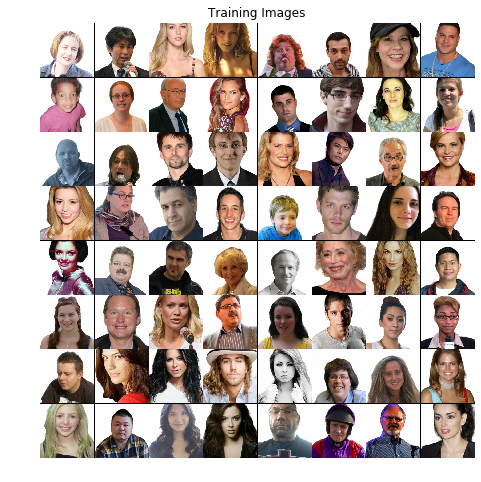

In [5]:
real_batch = next(iter(PortraitData))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, 64 * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 16),
            nn.ReLU(True),
            
            # state size. 64*16 x 4 x 4
            nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            
            # state size. 64*8 x 8 x 8
            nn.ConvTranspose2d( 64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            
            # state size. 64*4 x 16 x 16
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            
            # state size. 64*2x 32 x 32
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # state size. 64 x 64 x 64
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            # state size. 32 x 128 x 128
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 512 x 512
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64 x 256 x 256
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64*2 x 128 x 128
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64*4 x 64 x 64
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64*8 x 32 x 32
            nn.Conv2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64*4 x 16 x 16
            nn.Conv2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64 x 4 x 4
            nn.Conv2d(64*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
G_net = Generator().to(device)
D_net = Discriminator().to(device)
G_net = nn.DataParallel(G_net)
D_net = nn.DataParallel(D_net)
G_optim = torch.optim.Adam(G_net.parameters(), lr = 0.0002, betas = (0.5, 0.999))
D_optim = torch.optim.Adam(D_net.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [9]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1
fake_label = 0

In [10]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epo in range(10):
    for i, data in enumerate(PortraitData, 0):
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device = device)
        output = D_net(real_data).view(-1)
        real_error = criterion(output, label)
        D_optim.zero_grad()
        real_error.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, 100, 1, 1,device = device)
        fake_data = G_net(noise)
        label.fill_(fake_label)
        output = D_net(fake_data.detach()).view(-1)
        fake_error = criterion(output, label)
        fake_error.backward()
        D_G_z1 = output.mean().item()
        err_D = real_error + fake_error
        D_optim.step()
        
        label.fill_(real_label)
        output = D_net(fake_data).view(-1)
        err_G = criterion(output, label)
        G_optim.zero_grad()
        err_G.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epo, 10, i, len(PortraitData),
                     err_D.item(), err_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epo == 10-1) and (i == len(PortraitData)-1)):
            with torch.no_grad():
                fake = G_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1        

[0/10][0/538]	Loss_D: 1.3817	Loss_G: 2.3055	D(x): 0.5071	D(G(z)): 0.4982 / 0.1030
[0/10][50/538]	Loss_D: 0.0336	Loss_G: 4.8419	D(x): 0.9929	D(G(z)): 0.0261 / 0.0079
[0/10][100/538]	Loss_D: 0.0110	Loss_G: 5.7710	D(x): 0.9972	D(G(z)): 0.0082 / 0.0031
[0/10][150/538]	Loss_D: 0.0061	Loss_G: 6.0247	D(x): 0.9980	D(G(z)): 0.0041 / 0.0024
[0/10][200/538]	Loss_D: 0.0043	Loss_G: 6.2336	D(x): 0.9982	D(G(z)): 0.0025 / 0.0020
[0/10][250/538]	Loss_D: 0.0023	Loss_G: 6.5123	D(x): 0.9996	D(G(z)): 0.0020 / 0.0015
[0/10][300/538]	Loss_D: 0.0012	Loss_G: 7.1384	D(x): 0.9997	D(G(z)): 0.0009 / 0.0008
[0/10][350/538]	Loss_D: 0.0010	Loss_G: 7.2429	D(x): 0.9998	D(G(z)): 0.0008 / 0.0007
[0/10][400/538]	Loss_D: 0.0010	Loss_G: 7.3399	D(x): 0.9997	D(G(z)): 0.0008 / 0.0007
[0/10][450/538]	Loss_D: 0.0007	Loss_G: 7.6973	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[0/10][500/538]	Loss_D: 0.0005	Loss_G: 7.9578	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[1/10][0/538]	Loss_D: 0.0004	Loss_G: 8.1651	D(x): 0.9999	D(G(z)): 0.0003 / 0.00

[8/10][500/538]	Loss_D: 0.0040	Loss_G: 6.9035	D(x): 0.9978	D(G(z)): 0.0018 / 0.0011
[9/10][0/538]	Loss_D: 0.0057	Loss_G: 8.2300	D(x): 0.9948	D(G(z)): 0.0004 / 0.0003
[9/10][50/538]	Loss_D: 0.0258	Loss_G: 6.0331	D(x): 0.9861	D(G(z)): 0.0056 / 0.0024
[9/10][100/538]	Loss_D: 0.0015	Loss_G: 7.5361	D(x): 0.9991	D(G(z)): 0.0006 / 0.0005
[9/10][150/538]	Loss_D: 0.0014	Loss_G: 7.3650	D(x): 0.9993	D(G(z)): 0.0007 / 0.0006
[9/10][200/538]	Loss_D: 0.0021	Loss_G: 6.5372	D(x): 0.9996	D(G(z)): 0.0018 / 0.0015
[9/10][250/538]	Loss_D: 0.0013	Loss_G: 7.1627	D(x): 0.9997	D(G(z)): 0.0009 / 0.0008
[9/10][300/538]	Loss_D: 0.0011	Loss_G: 7.2630	D(x): 0.9997	D(G(z)): 0.0008 / 0.0007
[9/10][350/538]	Loss_D: 0.0015	Loss_G: 6.7725	D(x): 0.9997	D(G(z)): 0.0013 / 0.0011
[9/10][400/538]	Loss_D: 0.0008	Loss_G: 7.9087	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004
[9/10][450/538]	Loss_D: 0.0008	Loss_G: 7.3586	D(x): 0.9998	D(G(z)): 0.0007 / 0.0006
[9/10][500/538]	Loss_D: 0.0006	Loss_G: 7.8427	D(x): 0.9998	D(G(z)): 0.0004 / 0.

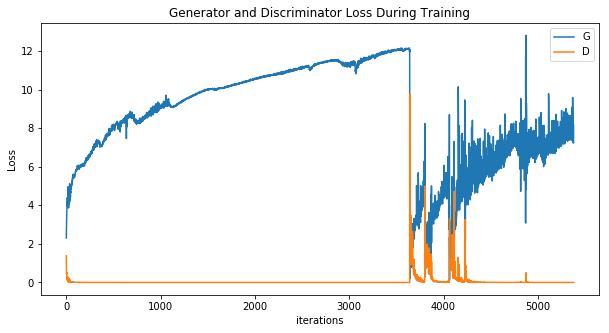

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

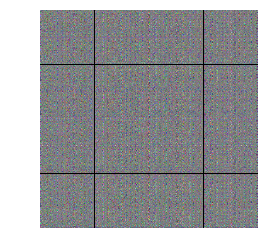

In [12]:
from IPython.display import HTML
fig = plt.figure(figsize=(8,4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

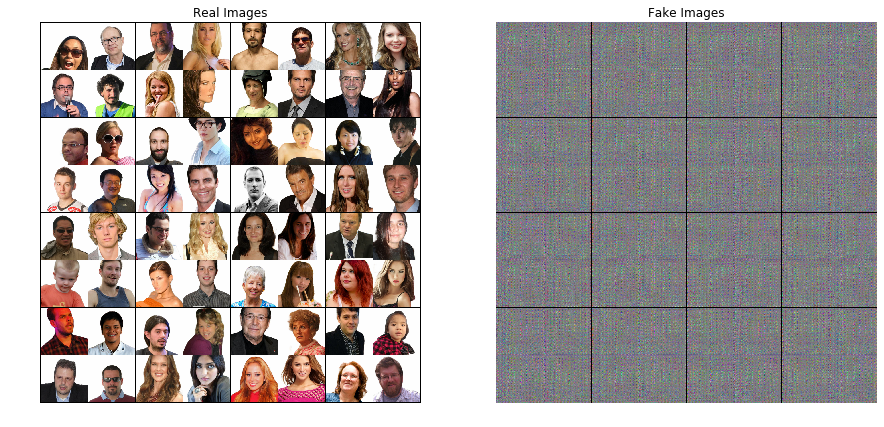

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(PortraitData))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()